In [1]:
from autometrics.dataset.datasets import HelpSteer
from autometrics.util.analysis import display_top_5_metrics_by_validation, get_top_metric_by_validation, plot_metric_target_scatterplot
from autometrics.aggregator.regression import Ridge
from autometrics.generator.LLMJudgeProposer import LLMJudgeProposer
import dspy
import litellm
from prometheus_eval.litellm import LiteLLM

import pandas as pd

pd.set_option('display.max_colwidth', None)

litellm.suppress_debug_info = True

/opt/miniconda3/envs/auto_eval/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
dataset = HelpSteer()

In [3]:
train, dev, test = dataset.get_splits(train_ratio=0.2, val_ratio=0.1, seed=42, max_size=1000)

In [4]:
llama31_70b = dspy.LM("openai/meta-llama/Meta-Llama-3.1-70b-Instruct", api_base="http://future-hgx-1:7410/v1", api_key="None")

dspy.settings.configure(lm=llama31_70b)

In [5]:
generator = LLMJudgeProposer(train_dataset=train, task_description="Answer the user query as a helpful chatbot assistant.", proposer_model=llama31_70b, judge_model=llama31_70b)

In [6]:
llama31_70b.model

'openai/meta-llama/Meta-Llama-3.1-70b-Instruct'

In [7]:
new_metrics = []

for target_column in dataset.target_columns:
    new_metrics.extend(generator.generate(train, target_column))

In [8]:
# Condense the metrics that have duplicate names
new_metrics_names = set()
new_metrics_final = []
for metric in new_metrics:
    if metric.name not in new_metrics_names:
        new_metrics_names.add(metric.name)
        new_metrics_final.append(metric)

In [9]:
train.add_metrics(new_metrics_final)
dev.add_metrics(new_metrics_final)
test.add_metrics(new_metrics_final)

Grading rows:  34%|███▎      | 336/1000 [00:01<00:03, 220.44row/s] 

Error processing row 5410: could not convert string to float: 'N/A'


Grading rows:  90%|████████▉ | 896/1000 [00:05<00:00, 125.50row/s]

Error processing row 2615: could not convert string to float: 'N/A'


Grading rows:  37%|███▋      | 659/1789 [00:03<00:04, 263.33row/s] 

Error processing row 608: Expected dict_keys(['reasoning', 'score']) but got dict_keys(['reasoning'])


Grading rows: 100%|██████████| 1789/1789 [00:06<00:00, 277.66row/s]


In [10]:
display_top_5_metrics_by_validation(dev, test, True)

,Top 1 Metric & Value,Top 2 Metric & Value,Top 3 Metric & Value,Top 4 Metric & Value,Top 5 Metric & Value
helpfulness,Accuracy_Meta-Llama-3.1-70b-Instruct (nan),Contextual understanding_Meta-Llama-3.1-70b-Instruct (0.4477223417573244),Coherence_Meta-Llama-3.1-70b-Instruct (0.4504531940982247),Informative value_Meta-Llama-3.1-70b-Instruct (0.4839150436345602),Relevance_Meta-Llama-3.1-70b-Instruct (0.4661231676503594)
correctness,Accuracy_Meta-Llama-3.1-70b-Instruct (nan),Coherence_Meta-Llama-3.1-70b-Instruct (0.44929705887857646),Relevance_Meta-Llama-3.1-70b-Instruct (0.46410884787576373),Informative value_Meta-Llama-3.1-70b-Instruct (0.4745493964935202),Contextual understanding_Meta-Llama-3.1-70b-Instruct (0.44004493100380415)
coherence,Accuracy_Meta-Llama-3.1-70b-Instruct (nan),Contextual understanding_Meta-Llama-3.1-70b-Instruct (0.3249545448469289),Coherence_Meta-Llama-3.1-70b-Instruct (0.3202154925772133),Relevance_Meta-Llama-3.1-70b-Instruct (0.34868954171048644),Conciseness_Meta-Llama-3.1-70b-Instruct (0.2505972282368095)
complexity,Engagement_Meta-Llama-3.1-70b-Instruct (0.28049555084988514),Completeness_Meta-Llama-3.1-70b-Instruct (0.2818820044696545),Informative value_Meta-Llama-3.1-70b-Instruct (0.16466861154932316),Tone_Meta-Llama-3.1-70b-Instruct (0.13838070971685512),Grammar and syntax_Meta-Llama-3.1-70b-Instruct (0.18420248668417935)
verbosity,Engagement_Meta-Llama-3.1-70b-Instruct (0.3456003023677312),Completeness_Meta-Llama-3.1-70b-Instruct (0.3087482950482836),Conciseness_Meta-Llama-3.1-70b-Instruct (-0.16186319481609845),Informative value_Meta-Llama-3.1-70b-Instruct (0.142585753545761),Grammar and syntax_Meta-Llama-3.1-70b-Instruct (0.1638828687211013)


In [11]:
from tqdm import tqdm
for target in tqdm(dataset.get_target_columns()):
    aggregator = Ridge(dataset=train, name=f'Ridge_{target}_llm')
    aggregator.ensure_dependencies(train)
    aggregator.ensure_dependencies(dev)
    aggregator.ensure_dependencies(test)

100%|██████████| 5/5 [00:03<00:00,  1.45it/s]


In [12]:
train.get_metric_columns()

['Relevance_Meta-Llama-3.1-70b-Instruct',
 'Coherence_Meta-Llama-3.1-70b-Instruct',
 'Completeness_Meta-Llama-3.1-70b-Instruct',
 'Tone_Meta-Llama-3.1-70b-Instruct',
 'Contextual understanding_Meta-Llama-3.1-70b-Instruct',
 'Accuracy_Meta-Llama-3.1-70b-Instruct',
 'Engagement_Meta-Llama-3.1-70b-Instruct',
 'Informative value_Meta-Llama-3.1-70b-Instruct',
 'Grammar and syntax_Meta-Llama-3.1-70b-Instruct',
 'Conciseness_Meta-Llama-3.1-70b-Instruct']

In [13]:
for target in tqdm(dataset.get_target_columns()):
    aggregator = Ridge(dataset=train, name=f'Ridge_{target}_llm')
    aggregator.learn(train, target)
    aggregator.predict(train)
    aggregator.predict(dev)
    aggregator.predict(test)

  0%|          | 0/5 [00:00<?, ?it/s]


ValueError: Input X contains NaN.
Ridge does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

In [ ]:
display_top_5_metrics_by_validation(dev, test, True)

,Top 1 Metric & Value,Top 2 Metric & Value,Top 3 Metric & Value,Top 4 Metric & Value,Top 5 Metric & Value
time_sec,Rg_time_sec_llm (0.8015867402194609),Rg_omissions_llm (0.7444499305949195),edited_note | Levenshtein dist. (-0.7918037570...,Rg_ipo_llm (0.7716906678804651),edited_note | WIL (-0.6588840227717595)
incorrect,Rg_incorrect_llm (0.7768831438191761),edited_note | ROUGE-L-Pr* (-0.7769928679302135),max | ROUGE-L-Pr* (-0.7432622187550944),Rg_ipo_llm (0.6594871106478493),avg | WIL (-0.5855855925864584)
omissions,Rg_omissions_llm (0.8354428610606931),edited_note | Levenshtein dist. (-0.8147010748...,edited_note | BLEU* (-0.7869679083840544),Rg_ipo_llm (0.7738952236676938),edited_note | ROUGE-L-Re* (-0.7728796627697061)
inc_plus_omi,Rg_ipo_llm (0.8547013281823652),Rg_omissions_llm (0.7941790251023849),avg | WIL (-0.7337000553443466),edited_note | Levenshtein dist. (-0.8215430062...,edited_note | BertScore* (-0.8014333508586717)


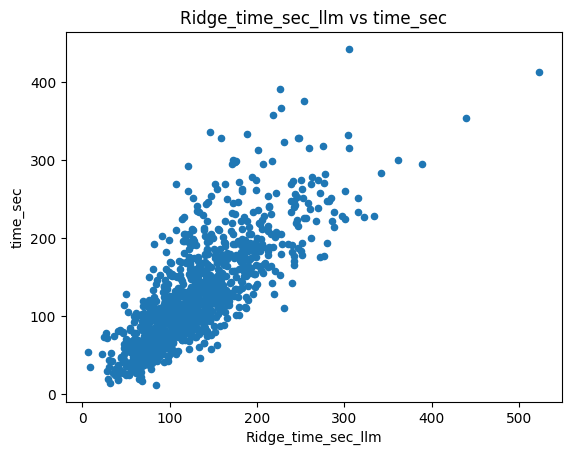

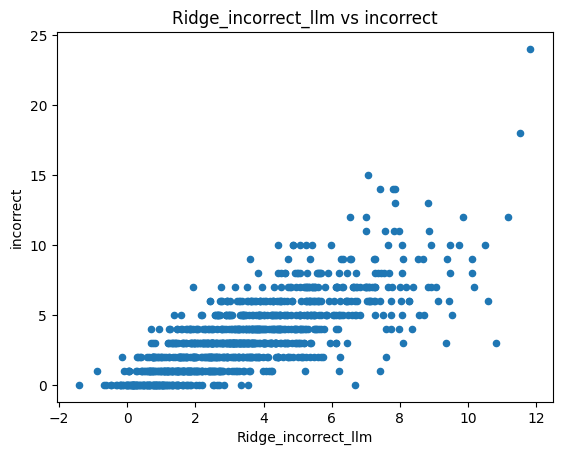

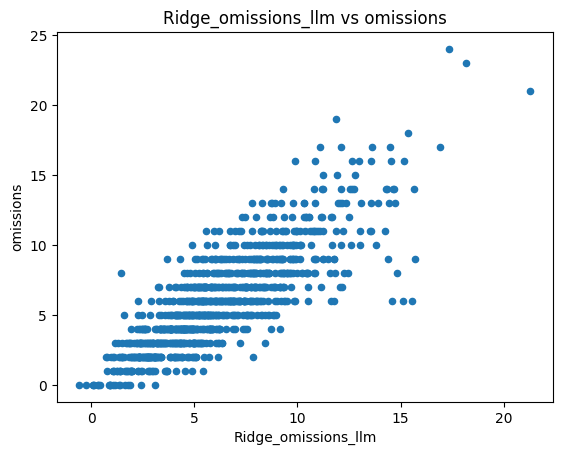

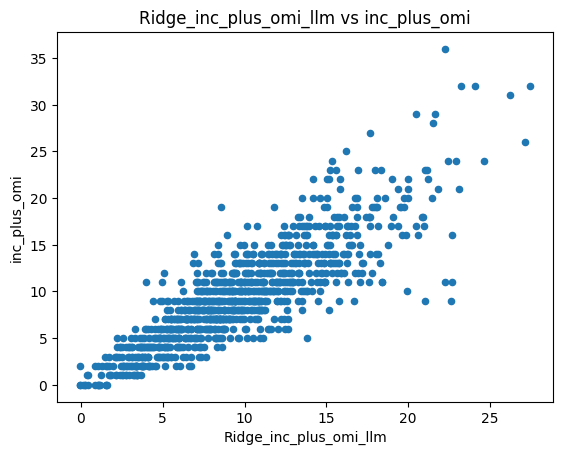

In [ ]:
for target_column in dataset.target_columns:
    metric = get_top_metric_by_validation(dev, target_column, True)
    plot_metric_target_scatterplot(test, metric, target_column)
